# System Identification

In [1]:
import os
import yaml
import casadi as cas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot_utils import make_ioplots, make_ioplots_combined
from sysid_utils import make_one_step_simulator, make_n_step_simulator, make_gauss_newton_solver

In [2]:
data_dir = "results"
os.listdir(data_dir)

['sim_results_peak_heat_day_u_prbs2.csv',
 'sim_results_peak_heat_day_u0_0.csv',
 'sim_results_peak_heat_day_u_prbs1.csv',
 'sim_results_peak_heat_day_u0_5.csv',
 'available_inputs.yaml',
 'sim_results_peak_heat_day_u1_0.csv',
 'available_measurements.yaml']

In [3]:
filename = "sim_results_peak_heat_day_u_prbs2.csv"

sim_results = pd.read_csv(os.path.join(data_dir, filename), index_col=0)
sim_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60481 entries, 0 to 60480
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time                    60481 non-null  int64  
 1   time_days               60481 non-null  float64
 2   oveHeaPumY_u            60481 non-null  float64
 3   reaTZon_y               60481 non-null  float64
 4   weaSta_reaWeaHDirNor_y  60481 non-null  float64
 5   weaSta_reaWeaTDryBul_y  60481 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 3.2 MB


In [4]:
sim_results.columns

Index(['time', 'time_days', 'oveHeaPumY_u', 'reaTZon_y',
       'weaSta_reaWeaHDirNor_y', 'weaSta_reaWeaTDryBul_y'],
      dtype='object')

In [5]:
filename = "available_inputs.yaml"
with open(os.path.join(data_dir, filename), 'r') as f:
    available_inputs = yaml.safe_load(f.read())

filename = "available_measurements.yaml"
with open(os.path.join(data_dir, filename), 'r') as f:
    available_measurements = yaml.safe_load(f.read())

In [6]:
sim_results.set_index('time').loc[slice(None, None)]

,time_days,oveHeaPumY_u,reaTZon_y,weaSta_reaWeaHDirNor_y,weaSta_reaWeaTDryBul_y
time,,,,,
777600,9.000000,0.720000,293.150000,0.0,271.250000
777630,9.000347,0.747462,293.108808,0.0,271.249092
777660,9.000694,0.774587,293.068329,0.0,271.248037
777690,9.001042,0.801175,293.028897,0.0,271.246837
777720,9.001389,0.827109,292.990700,0.0,271.245496
...,...,...,...,...,...
2591880,29.998611,0.500000,292.013617,0.0,273.458772
2591910,29.998958,0.500000,292.014879,0.0,273.456542
2591940,29.999306,0.500000,292.016140,0.0,273.454337


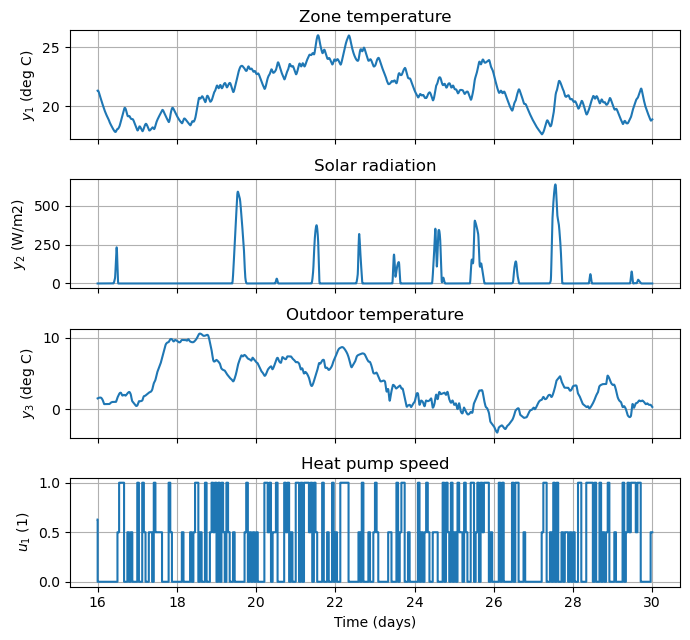

In [7]:
N = sim_results.shape[0] - 1
input_names = ['oveHeaPumY_u']
measurement_names = ['reaTZon_y', 'weaSta_reaWeaHDirNor_y', 'weaSta_reaWeaTDryBul_y']
time_range = slice(16, None)

var_rename_map = {
    'oveHeaPumY_u': 'Heat pump speed',
    'reaTZon_y': 'Zone temperature', 
    'weaSta_reaWeaHDirNor_y': 'Solar radiation', 
    'weaSta_reaWeaTDryBul_y': 'Outdoor temperature'
}

fig, axes = make_ioplots(
    sim_results,
    input_names,
    measurement_names,
    available_inputs,
    available_measurements,
    time_name='time_days',
    time_range=time_range,
    var_rename_map=var_rename_map
)
plt.tight_layout()
plt.show()

In [8]:
# Standardize data

nominal_values = {
    'oveHeaPumY_u': 0.0,
    'reaTZon_y': 273.15 + 0.0, 
    'weaSta_reaWeaHDirNor_y': 0.0, 
    'weaSta_reaWeaTDryBul_y': 273.15 + 0.0  # must be same as 'reaTZon_y'
}

scale_factors = {
    'oveHeaPumY_u': 0.1,
    'reaTZon_y': 1.0,
    'weaSta_reaWeaHDirNor_y': 100.0,
    'weaSta_reaWeaTDryBul_y': 1.0
}

sim_results_scaled = sim_results[['time', 'time_days']].copy()
for name in measurement_names:
    new_name = f"{name}_scaled"
    sim_results_scaled[new_name] = (sim_results[name] - nominal_values[name]) / scale_factors[name]
for name in input_names:
    new_name = f"{name}_scaled"
    sim_results_scaled[new_name] = (sim_results[name] - nominal_values[name]) / scale_factors[name]

sim_results_scaled.describe()

,time,time_days,reaTZon_y_scaled,weaSta_reaWeaHDirNor_y_scaled,weaSta_reaWeaTDryBul_y_scaled,oveHeaPumY_u_scaled
count,6.048100e+04,60481.000000,60481.000000,60481.000000,60481.000000,60481.000000
mean,1.684800e+06,19.500000,21.144611,0.272019,4.180301,3.236828
std,5.237852e+05,6.062328,1.656711,0.896382,3.221328,3.693923
min,7.776000e+05,9.000000,17.593413,0.000000,-3.305276,0.000000
25%,1.231200e+06,14.250000,20.325497,0.000000,1.423139,0.000000
50%,1.684800e+06,19.500000,21.119687,0.000000,4.159360,1.798515
75%,2.138400e+06,24.750000,21.888271,0.000000,6.721582,5.000000
max,2.592000e+06,30.000000,26.030432,6.387699,10.600581,10.000000


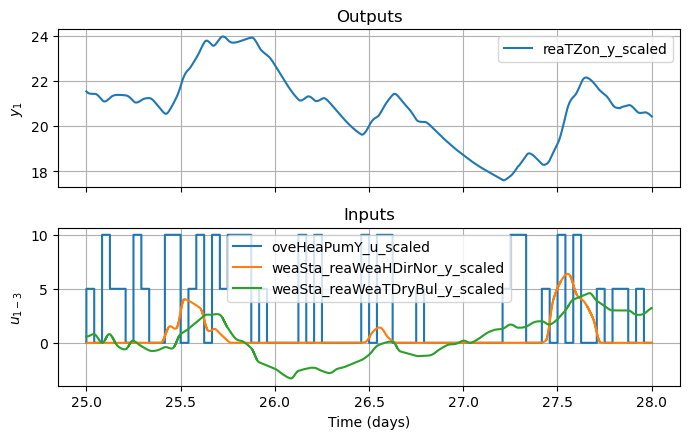

In [9]:
time_range = slice(18.5, 20.5)
time_range = slice(25, 28)

data_sample = (
    sim_results_scaled
    .set_index('time_days').loc[time_range]
    .reset_index().set_index('time')
)

input_names = ['oveHeaPumY_u_scaled', 'weaSta_reaWeaHDirNor_y_scaled', 'weaSta_reaWeaTDryBul_y_scaled']
measurement_names = ['reaTZon_y_scaled']

fig, axes = make_ioplots_combined(
    sim_results_scaled,
    input_names,
    measurement_names,
    available_inputs,
    available_measurements,
    time_name='time_days',
    time_range=time_range,
    var_rename_map=var_rename_map,
)
plt.tight_layout()
plt.show()

## Models

$$
C \frac{d T}{d t}(t) = -H \left( T(t) - T_a(t) \right) + \dot{Q}_h(t) + \dot{Q}_{\text {rad}}(t) + \dot{Q}_{\text {other}}(t)
$$

$$
\dot{Q}_{\text {rad}}(t) = K_R R(t)
$$

In [10]:
# Parameters
C = 5 * 3.6e6  # thermal capacitance, W/°C
H = cas.MX.sym('H')   # scaled heat transfer coefficient with ambient, kW/°C
K_heat = cas.MX.sym('K_heat')  # unknown constant relating heater setting to heat input
K_rad = cas.MX.sym('K_rad')  # unknown constant relating measured solar radiation to heat input
params = [H, K_heat, K_rad]

# System dimensions
n_x = 1  # number of states
n_u = 1  # number of manipulated inputs
n_p = 2  # number of disturbance inputs

# Declare system variables
x = cas.MX.sym('x', n_x)  # states
u = cas.MX.sym('u', n_u)  # manipulated inputs
p = cas.MX.sym('p', n_p)  # disturbance inputs

# Aliases
T = x[0]  # zone temperature
Q_h = u[0]  # heating delivered
T_a = p[0]  # ambient temperature
R = p[1]  # solar insolation

# Rate-of-change of zone temperature
dTdt = (-H * (T - T_a) + K_heat * Q_h + K_rad * R) / C

# Define ODE
states = x
rhs = dTdt
inputs = cas.vertcat(u, p)
params = cas.vcat(params)
f = cas.Function('f', [states, inputs, params], [rhs], ['states', 'inputs', 'params'], ['rhs'])
print(f"ODE rhs: {f}")

# Make simulator
Ts = 5 * 60
n_steps_per_sample = 10
dt = Ts / n_steps_per_sample
sample_step = make_n_step_simulator(f, dt, states, inputs, params, n_steps=n_steps_per_sample)
print(f"Sample step simulator: {sample_step}")

ODE rhs: f:(states,inputs[3],params[3])->(rhs) MXFunction
Sample step simulator: RK4_10_steps:(states,inputs[3],params[3])->(X) MXFunction


## Test functions

In [11]:
data_sample.describe()

,time_days,reaTZon_y_scaled,weaSta_reaWeaHDirNor_y_scaled,weaSta_reaWeaTDryBul_y_scaled,oveHeaPumY_u_scaled
count,8641.000000,8641.000000,8641.000000,8641.000000,8641.000000
mean,26.500000,20.839129,0.644509,0.366380,3.471820
std,0.866176,1.631037,1.422880,1.951420,4.219737
min,25.000000,17.593413,0.000000,-3.305276,0.000000
25%,25.750000,19.857362,0.000000,-1.001667,0.000000
50%,26.500000,21.037344,0.000000,0.105359,0.000000
75%,27.250000,21.473806,0.224597,1.840000,5.000000
max,28.000000,23.965564,6.387699,4.610726,10.000000


In [12]:
f

Function(f:(states,inputs[3],params[3])->(rhs) MXFunction)

In [13]:
test_params = {
    'states': cas.DM([20.0]),
    'inputs': cas.DM([5.0, 0.0, 1.0]),
    'params': cas.DM([1.0, 1.0, 1.0])
}

def test_ode(params=test_params):
    states = test_params['states']
    inputs = test_params['inputs']
    params = test_params['params']
    return f(states, inputs, params)

test_ode()

DM(-7.77778e-07)

In [14]:
one_step = make_one_step_simulator(f, dt, states, inputs, params, name='RK4')
one_step

Function(RK4:(states,inputs[3],params[3])->(states_final) MXFunction)

In [15]:
def test_one_step(params=test_params):
    states = test_params['states']
    inputs = test_params['inputs']
    params = test_params['params']
    return one_step(states, inputs, params)

test_one_step()

DM(20)

In [16]:
n_step = make_n_step_simulator(f, dt, states, inputs, params, n_steps=2)
n_step

Function(RK4_2_steps:(states,inputs[3],params[3])->(X) MXFunction)

In [17]:
def test_n_step(params=test_params):
    states = test_params['states']
    inputs = test_params['inputs']
    params = test_params['params']
    return n_step(states, inputs, params)

test_n_step()

DM(20)

In [18]:
def test_2_step2(params=test_params):
    states = test_params['states']
    inputs = test_params['inputs']
    params = test_params['params']
    print(states.__repr__())
    x2 = one_step(states, inputs, params)
    print(x2.__repr__())
    x3 = one_step(x2, inputs, params)
    print(x3.__repr__())
    x4 = one_step(x3, inputs, params)
    print(x4.__repr__())

test_2_step2()

DM(20)
DM(20)
DM(20)
DM(19.9999)


In [19]:
def test_simulate(params=test_params):
    N = 12
    simulate = sample_step.mapaccum("simulate", N)
    states = test_params['states']
    inputs = test_params['inputs']
    params = test_params['params']
    return simulate(states, cas.repmat(inputs, 1, N), cas.repmat(params, 1, N))

test_simulate()

DM([[19.9998, 19.9995, 19.9993, 19.9991, 19.9988, 19.9986, 19.9984, 19.9981, 19.9979, 19.9977, 19.9974, 19.9972]])

simulate:(states,inputs[3x8641],params[3x8641])->(X[1x8641]) MXFunction


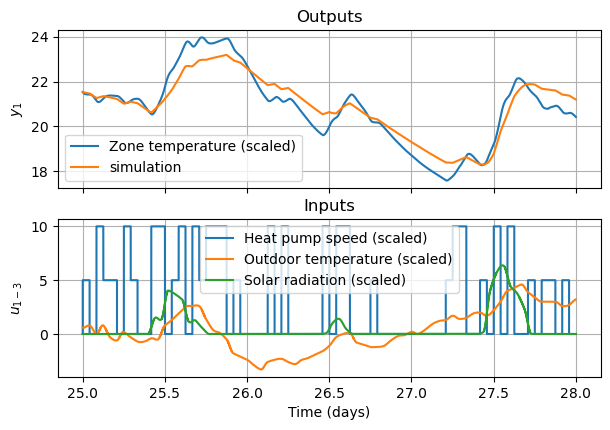

sumsqr(errors): 2615


In [20]:
# Try simulating system with initial parameter values
params_initial_guess = cas.DM([5, 15, 75])

# Initial condition
T0 = data_sample['reaTZon_y_scaled'].iloc[0]
x0 = cas.DM([T0])

N = data_sample.shape[0]  # Number of samples

# Make function to simulate whole trajectory
simulate = sample_step.mapaccum("simulate", N)
print(simulate)

# Structure of input signals
# Q_c = u[0]  # cooling delivered
# T_a = p[0]  # ambient temperature
# R = p[1]  # solar insolation
input_names = ['oveHeaPumY_u_scaled', 'weaSta_reaWeaTDryBul_y_scaled', 'weaSta_reaWeaHDirNor_y_scaled']
inputs = cas.DM(data_sample[input_names].to_numpy()).T
assert inputs.shape == (n_u + n_p, N)
X = simulate(x0, inputs, cas.repmat(params_initial_guess, 1, N))
assert X.shape == (n_x, N)

var_rename_map = {
    'oveHeaPumY_u_scaled': 'Heat pump speed (scaled)',
    'reaTZon_y_scaled': 'Zone temperature (scaled)', 
    'weaSta_reaWeaHDirNor_y_scaled': 'Solar radiation (scaled)', 
    'weaSta_reaWeaTDryBul_y_scaled': 'Outdoor temperature (scaled)'
}

fig, axes = make_ioplots_combined(
    sim_results_scaled,
    input_names,
    measurement_names,
    available_inputs,
    available_measurements,
    time_name='time_days',
    time_range=time_range,
    var_rename_map=var_rename_map,
)
axes[0].plot(data_sample['time_days'], X.T, label='simulation')
axes[0].legend()
plt.show()

output_names = ['reaTZon_y_scaled']
Y_measured = cas.DM(data_sample[output_names].to_numpy()).T
Y_predicted = X[0, :]
errors = Y_measured - Y_predicted
print(f"sumsqr(errors): {float(cas.sumsqr(errors)):.0f}")

## Identify system parameters

### 1. Single shooting strategy

In [21]:
data_sample.head()

,time_days,reaTZon_y_scaled,weaSta_reaWeaHDirNor_y_scaled,weaSta_reaWeaTDryBul_y_scaled,oveHeaPumY_u_scaled
time,,,,,
2160000,25.000000,21.533607,0.0,0.600000,0.0
2160030,25.000347,21.530032,0.0,0.598239,5.0
2160060,25.000694,21.526490,0.0,0.596639,5.0
2160090,25.001042,21.523004,0.0,0.595197,5.0
2160120,25.001389,21.519587,0.0,0.593910,5.0


In [22]:
# Initial condition
T0 = data_sample['reaTZon_y_scaled'].iloc[0]
x0 = cas.DM([T0])

print(f"params_initial_guess: {params_initial_guess}")

# Note, it is in general a good idea to scale your decision variables such
# that they are in the order of ~0.1..100
params_scale_factors = cas.vertcat(1.0, 1.0, 1.0)

# Structure of input signals
# Q_c = u[0]  # cooling delivered
# T_a = p[0]  # ambient temperature
# R = p[1]  # solar insolation
input_names = ['oveHeaPumY_u_scaled', 'weaSta_reaWeaTDryBul_y_scaled', 'weaSta_reaWeaHDirNor_y_scaled']
inputs = cas.DM(data_sample[input_names].to_numpy()).T
scaled_params = cas.repmat(params * params_scale_factors, 1, N)
X_symbolic = simulate(x0, inputs, scaled_params)

output_names = ['reaTZon_y_scaled']
Y_measured = cas.DM(data_sample[output_names].to_numpy()).T

# # x[0] is zone temperature
Y = X_symbolic[0, :]
errors = Y_measured - Y

# Make NLP solver
solver = make_gauss_newton_solver(errors, params)
print(solver)

sol = solver(x0=params_initial_guess / params_scale_factors)
scaled_params_sol = sol['x']

print(f"Scaled params: {scaled_params_sol}")
print(f"Solution: {scaled_params_sol * params_scale_factors}")

params_initial_guess: [5, 15, 75]
solver:(x0[3],p[],lbx[3],ubx[3],lbg[0],ubg[0],lam_x0[3],lam_g0[0])->(x[3],f,g[0],lam_x[3],lam_g[0],lam_p[]) IpoptInterface

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0

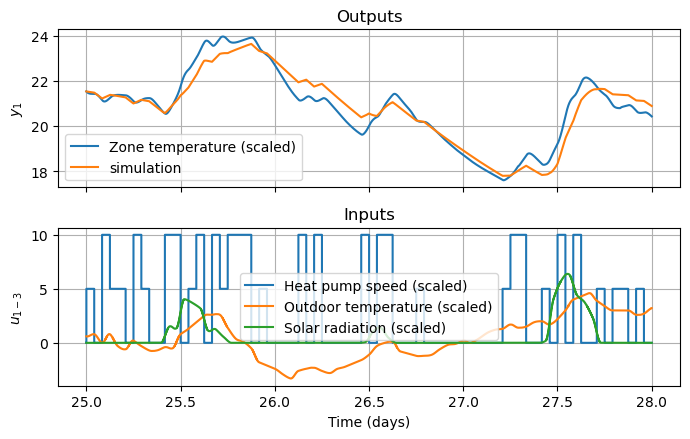

sumsqr(errors): 1961


In [23]:
# Initial condition
T0 = data_sample['reaTZon_y_scaled'].iloc[0]
x0 = cas.DM([T0])

# Structure of input signals
# Q_c = u[0]  # cooling delivered
# T_a = p[0]  # ambient temperature
# R = p[1]  # solar insolation
input_names = ['oveHeaPumY_u_scaled', 'weaSta_reaWeaTDryBul_y_scaled', 'weaSta_reaWeaHDirNor_y_scaled']
inputs = cas.DM(data_sample[input_names].to_numpy()).T
assert inputs.shape == (n_u + n_p, N)
scaled_params = cas.repmat(scaled_params_sol * params_scale_factors, 1, N)
X = simulate(x0, inputs, scaled_params)
assert X.shape == (n_x, N)

fig, axes = make_ioplots_combined(
    sim_results_scaled,
    input_names,
    measurement_names,
    available_inputs,
    available_measurements,
    time_name='time_days',
    time_range=time_range,
    var_rename_map=var_rename_map,
)
axes[0].plot(data_sample['time_days'], X.T, label='simulation')
axes[0].legend()

plt.tight_layout()
plt.show()

Y_predicted = X[0, :]
errors = Y_measured - Y_predicted
print(f"sumsqr(errors): {float(cas.sumsqr(errors)):.0f}")

### 2. Multiple-shooting strategy

In [24]:
# Initial condition
T0 = data_sample['reaTZon_y_scaled'].iloc[0]
x0 = cas.DM([T0])

print(f"params_initial_guess: {params_initial_guess}")

# Note, it is in general a good idea to scale your decision variables such
# that they are in the order of ~0.1..100
params_scale_factors = cas.vertcat(1.0, 1.0, 1.0)

# All states become decision variables
X = cas.MX.sym("X", n_x, N)

scaled_params = cas.repmat(params * params_scale_factors, 1, N)
Xn = sample_step.map(N, 'openmp')(X, inputs, scaled_params)
gaps = Xn[:, :-1] - X[:, 1:]

output_names = ['reaTZon_y_scaled']
Y_measured = cas.DM(data_sample[output_names].to_numpy()).T

# # x[0] is zone temperature
Y = Xn[0, :]

errors = Y_measured - Y
V = cas.veccat(params, X)
g = cas.vec(gaps)

# Multiple shooting allows for careful initialization
X_guess = Y_measured

x0 = cas.veccat(params_initial_guess, X_guess)
solver = make_gauss_newton_solver(errors, V, g)
print(solver)

sol = solver(x0=x0, lbg=0, ubg=0)

n_params = scaled_params.shape[0]
scaled_params_sol = sol['x'][:n_params]

print(f"Scaled params: {scaled_params_sol}")
print(f"Solution: {scaled_params_sol * params_scale_factors}")

params_initial_guess: [5, 15, 75]
solver:(x0[8644],p[],lbx[8644],ubx[8644],lbg[8640],ubg[8640],lam_x0[8644],lam_g0[8640])->(x[8644],f,g[8640],lam_x[8644],lam_g[8640],lam_p[]) IpoptInterface
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    43200
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    34570

Total number of variables............................:     8644
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     8640
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints wi

CasADi - 2025-01-04 22:42:51 WARNING("CasADi was not compiled with WITH_OPENMP=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:404]
CasADi - 2025-01-04 22:42:51 WARNING("CasADi was not compiled with WITH_OPENMP=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:404]
CasADi - 2025-01-04 22:42:53 WARNING("CasADi was not compiled with WITH_OPENMP=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:404]
CasADi - 2025-01-04 22:42:54 WARNING("CasADi was not compiled with WITH_OPENMP=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:404]


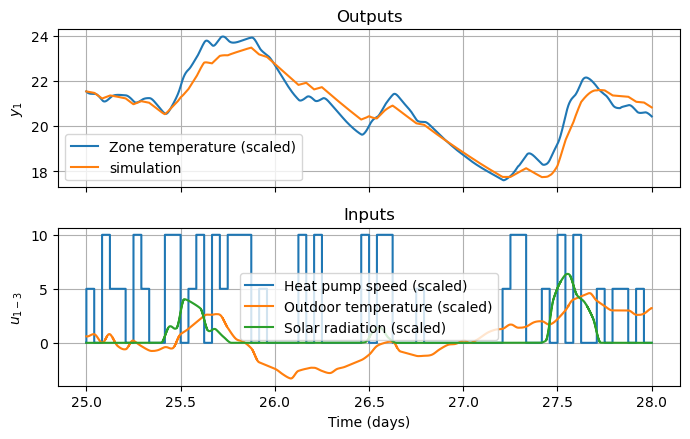

sumsqr(errors): 2045


In [25]:
# Initial condition
T0 = data_sample['reaTZon_y_scaled'].iloc[0]
x0 = cas.DM([T0])

# Structure of input signals
# Q_c = u[0]  # cooling delivered
# T_a = p[0]  # ambient temperature
# R = p[1]  # solar insolation
input_names = ['oveHeaPumY_u_scaled', 'weaSta_reaWeaTDryBul_y_scaled', 'weaSta_reaWeaHDirNor_y_scaled']
inputs = cas.DM(data_sample[input_names].to_numpy()).T
assert inputs.shape == (n_u + n_p, N)
scaled_params = cas.repmat(scaled_params_sol, 1, N)
X = simulate(x0, inputs, scaled_params)
assert X.shape == (n_x, N)

fig, axes = make_ioplots_combined(
    sim_results_scaled,
    input_names,
    measurement_names,
    available_inputs,
    available_measurements,
    time_name='time_days',
    time_range=time_range,
    var_rename_map=var_rename_map,
)
axes[0].plot(data_sample['time_days'], X.T, label='simulation')
axes[0].legend()

plt.tight_layout()
plt.show()

Y_predicted = X[0, :]
errors = Y_measured - Y_predicted
print(f"sumsqr(errors): {float(cas.sumsqr(errors)):.0f}")